## Installing 

In [ ]:
#Assuming python and conda are already installed in the system
#uncomment the following commands to install tensorflow and upgrade keras in your system

#!pip install tensorflow
#!pip install keras --upgrade

### Importing Necessary packages

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras import regularizers

In [45]:
#set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

#### Following commands were used to connect to Google  Drive as this notebook was executed in Colab.

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p My Drive
!google-drive-ocamlfuse My Drive


!ls My Drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > My Drive/created.txt

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
Drive/:
Colab Notebooks		     Report.odt
Copy of Design question.odt  Resume - Vidhyalakshimi Sreenivasan.odt
CoverLetter.docx	     Sem1
DB_populate.txt.odt	     Sem2
Ebooks			     Tensorflow Notebook
Getting started		     VidhyalakshimiSreenivasanResume1.pdf
IMG_6950.JPG		     VidhyalakshimiSreenivasanResume.

In [5]:
! ls Drive

Colab Notebooks		     Report.odt
Copy of Design question.odt  Resume - Vidhyalakshimi Sreenivasan.odt
CoverLetter.docx	     Sem1
DB_populate.txt.odt	     Sem2
Ebooks			     Tensorflow Notebook
Getting started		     VidhyalakshimiSreenivasanResume1.pdf
IMG_6950.JPG		     VidhyalakshimiSreenivasanResume.pdf
Project2 deliverables.odt


### Replace the file path with local file location

In [0]:
import pickle

train_data = pickle.load(open(r'Drive/Colab Notebooks/train_data.p', "rb" ))
eval_data = pickle.load(open(r'Drive/Colab Notebooks/test_data.p', "rb" ))

In [47]:
print(train_data.shape)
print(eval_data.shape)

(20000, 60, 60, 3)
(2000, 60, 60, 3)


In [0]:
train_labels = [0]*10000+[1]*10000

### LeNet Architecture

In [0]:
class LeNet:
	@staticmethod
	def build(width, height, depth, classes,reg):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)
        
		# first set of CONV => RELU => POOL layers
		model.add(Conv2D (30, (5, 5), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL layers
		model.add(Conv2D(60, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500, kernel_regularizer=regularizers.l2(reg)))
		model.add(Activation("relu"))
        
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

## Train model with Mini batch size = 50 and given params

In [0]:
def train_model(EPOCHS,INIT_LR,regu):
    BS=50
    print("[INFO] loading images...")
    data = train_data
    labels = train_labels

    # Preprocessing of data
    # scale the raw pixel intensities to the range [0, 1]
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)

    # Partition data into 75% training and 25% validation data
    (trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    trainY = to_categorical(trainY, num_classes=2)
    testY = to_categorical(testY, num_classes=2)

    # initialize the model
    print("[INFO] compiling model...")
    model = LeNet.build(width=60, height=60, depth=3, classes=2, reg=regu)
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

    aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


    # train the network
    print("[INFO] training network...")
    H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    # plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    # plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on Face/Not Face")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

## Baby sitting process

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
297/300 [============================>.] - ETA: 0s - loss: 0.1449 - acc: 0.9428300/300 [==============================] - 29s 96ms/step - loss: 0.1442 - acc: 0.9431 - val_loss: 0.1376 - val_acc: 0.9526
Epoch 2/15
300/300 [==============================] - 25s 82ms/step - loss: 0.0590 - acc: 0.9793 - val_loss: 0.0140 - val_acc: 0.9954
Epoch 3/15
115/300 [==========>...................] - ETA: 14s - loss: 0.0408 - acc: 0.9859300/300 [==============================] - 25s 85ms/step - loss: 0.0368 - acc: 0.9879 - val_loss: 0.0118 - val_acc: 0.9964
Epoch 4/15
300/300 [==============================] - 25s 82ms/step - loss: 0.0346 - acc: 0.9885 - val_loss: 0.0192 - val_acc: 0.9944
Epoch 5/15
 72/300 [======>.......................] - ETA: 16s - loss: 0.0265 - acc: 0.9911300/300 [==============================] - 25s 85ms/step - loss: 0.0252 - acc: 0.9911 - val_loss: 0.0101 - val_acc: 0.9968
Epoch 6/15
30

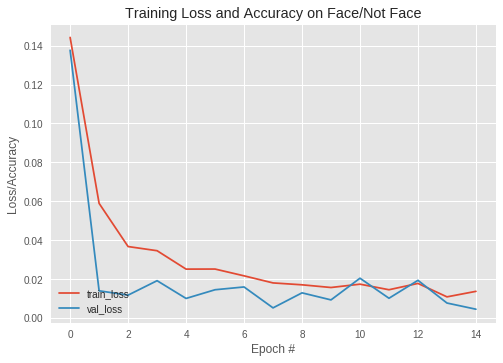

In [15]:
#Reg 0.0
train_model(EPOCHS = 15, INIT_LR = 1e-3, regu = 0.0 )

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
300/300 [==============================] - 27s 92ms/step - loss: 22153.2918 - acc: 0.8041 - val_loss: 0.7518 - val_acc: 0.8458
Epoch 2/15
164/300 [===============>..............] - ETA: 10s - loss: 0.6430 - acc: 0.8763300/300 [==============================] - 25s 85ms/step - loss: 0.8318 - acc: 0.8720 - val_loss: 2.2234 - val_acc: 0.8250
Epoch 3/15
300/300 [==============================] - 26s 88ms/step - loss: 1.1006 - acc: 0.8695 - val_loss: 0.5566 - val_acc: 0.8996
Epoch 4/15
 84/300 [=======>......................] - ETA: 16s - loss: 1.0526 - acc: 0.8738300/300 [==============================] - 25s 85ms/step - loss: 1.1643 - acc: 0.8793 - val_loss: 0.7152 - val_acc: 0.9304
Epoch 5/15
300/300 [==============================] - 26s 88ms/step - loss: 1.5669 - acc: 0.8569 - val_loss: 0.6639 - val_acc: 0.9318
Epoch 6/15
 66/300 [=====>........................] - ETA: 16s - loss: 1.7422 - acc: 0.8

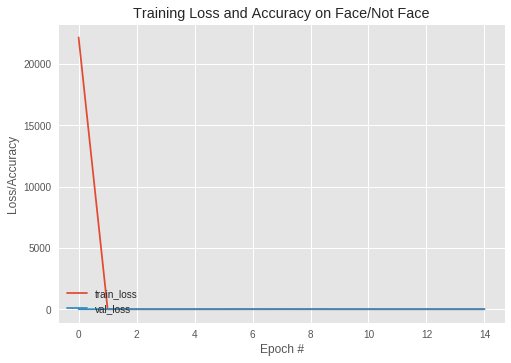

In [17]:
#Reg = 1e3 - Leads to increase in loss 
train_model(EPOCHS = 15, INIT_LR = 1e-3, regu = 1e3 )

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
300/300 [==============================] - 31s 102ms/step - loss: 0.0351 - acc: 0.9847 - val_loss: 1.3216e-06 - val_acc: 1.0000
Epoch 2/15
134/300 [============>.................] - ETA: 16s - loss: 1.2945e-04 - acc: 1.0000300/300 [==============================] - 30s 101ms/step - loss: 0.0492 - acc: 0.9918 - val_loss: 6.9189e-05 - val_acc: 1.0000
Epoch 3/15
300/300 [==============================] - 30s 101ms/step - loss: 2.3124e-04 - acc: 1.0000 - val_loss: 4.7148e-06 - val_acc: 1.0000
Epoch 4/15
 33/300 [==>...........................] - ETA: 26s - loss: 3.7155e-05 - acc: 1.0000300/300 [==============================] - 30s 101ms/step - loss: 5.5294e-05 - acc: 1.0000 - val_loss: 6.3990e-06 - val_acc: 1.0000
Epoch 5/15
300/300 [==============================] - 30s 101ms/step - loss: 2.5577e-05 - acc: 1.0000 - val_loss: 6.0692e-07 - val_acc: 1.0000
Epoch 6/15
  5/300 [...........................

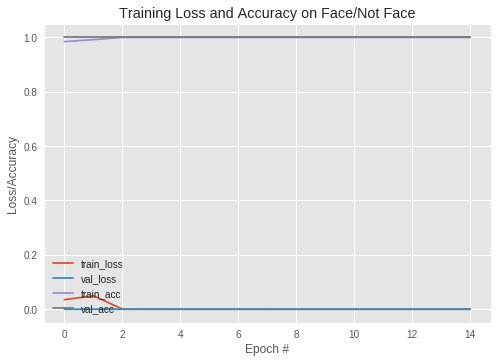

In [18]:
#Overfit with small proportion of training data
# Results in small loss and Training accuracy = 1

EPOCHS = 15
INIT_LR = 1e-3
BS = 50

print("[INFO] loading images...")
data = train_data
labels = train_labels

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)
 
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

#Small portion of training of data
trainX_small = trainX[:20]
trainY_small = trainY[:20]


# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=60, height=60, depth=3, classes=2, reg=0.0)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

# aug = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0)
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")


# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX_small, trainY_small, batch_size=BS),
	validation_data=(trainX_small, trainY_small), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Face/Not Face")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig()


[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
300/300 [==============================] - 27s 89ms/step - loss: 0.6842 - acc: 0.5094 - val_loss: 0.6852 - val_acc: 0.5024
Epoch 2/15
173/300 [================>.............] - ETA: 10s - loss: 0.6848 - acc: 0.5061300/300 [==============================] - 27s 89ms/step - loss: 0.6841 - acc: 0.5089 - val_loss: 0.6850 - val_acc: 0.5026
Epoch 3/15
300/300 [==============================] - 26s 85ms/step - loss: 0.6837 - acc: 0.5095 - val_loss: 0.6848 - val_acc: 0.5026
Epoch 4/15
 85/300 [=======>......................] - ETA: 16s - loss: 0.6856 - acc: 0.5007300/300 [==============================] - 26s 88ms/step - loss: 0.6835 - acc: 0.5087 - val_loss: 0.6846 - val_acc: 0.5026
Epoch 5/15
300/300 [==============================] - 25s 84ms/step - loss: 0.6835 - acc: 0.5081 - val_loss: 0.6844 - val_acc: 0.5026
Epoch 6/15
 64/300 [=====>........................] - ETA: 17s - loss: 0.6821 - acc: 0.50913

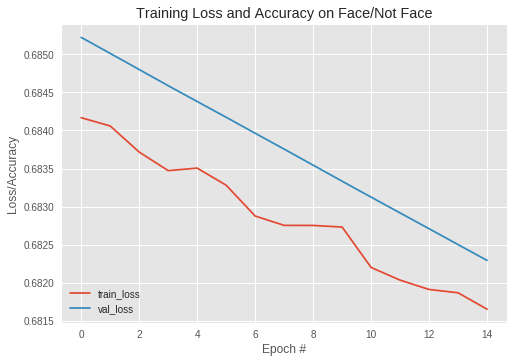

In [14]:
# small reg = 0.000001 and LR = 1e-9
# Gives bareely changing learning rate
train_model(EPOCHS = 15, INIT_LR = 1e-9, regu = 0.000001 )

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/15
300/300 [==============================] - 24s 81ms/step - loss: 6494798464437.4209 - acc: 0.4982 - val_loss: 9.5272 - val_acc: 0.5048
Epoch 2/15
156/300 [==============>...............] - ETA: 9s - loss: 8.0189 - acc: 0.5033300/300 [==============================] - 22s 75ms/step - loss: 8.0705 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 3/15
300/300 [==============================] - 23s 77ms/step - loss: 8.0408 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 4/15
 83/300 [=======>......................] - ETA: 15s - loss: 8.2894 - acc: 0.4829300/300 [==============================] - 24s 79ms/step - loss: 8.0408 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 5/15
300/300 [==============================] - 23s 76ms/step - loss: 8.0408 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 6/15
 67/300 [=====>........................] - ETA: 15s - loss: 8.0965 - a

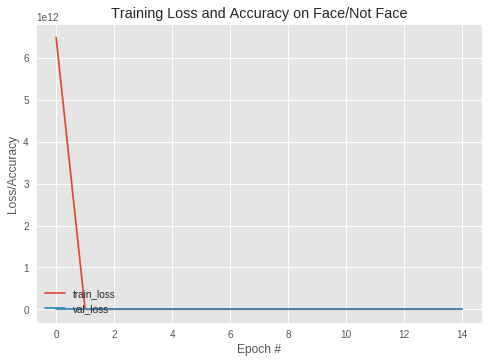

In [11]:
# Large LR = 1e9
# Gives highly changing loss value
train_model(EPOCHS = 15, INIT_LR = 1e9, regu = 1e6 )

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
300/300 [==============================] - 25s 83ms/step - loss: nan - acc: 0.0012 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/5
180/300 [=================>............] - ETA: 8s - loss: nan - acc: 0.0000e+00300/300 [==============================] - 23s 77ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/5
300/300 [==============================] - 23s 78ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/5
 87/300 [=======>......................] - ETA: 14s - loss: nan - acc: 0.0000e+00300/300 [==============================] - 23s 77ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/5
300/300 [==============================] - 23s 76ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00


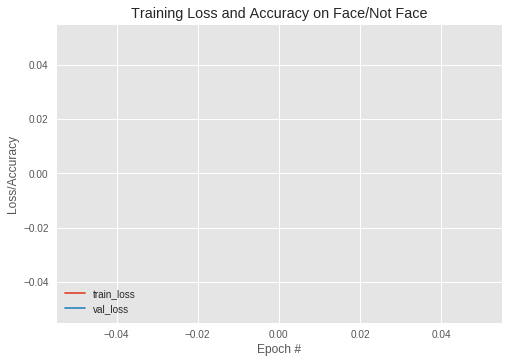

In [12]:
## Learning rate = 1e10
## Loss explodes to infinity
train_model(EPOCHS = 5, INIT_LR = 1e10, regu = 1e6 )

In [16]:
# Coarse search with range 
## Reg = -5 to 6
## Learning rate = -9 to 9
import random 
limit = 20
for count in range(limit):
  reg = 10**random.uniform(-5, 6)
  lr = 10**random.uniform(-9,9)
  print("Reg: "+str(reg)+", LR: " + str(lr))
  train_model(EPOCHS=5, INIT_LR=lr, regu = reg )

Reg: 1.2104492933255302, LR: 1.837549271999327e-09
[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
300/300 [==============================] - 25s 84ms/step - loss: 1166.7472 - acc: 0.4925 - val_loss: 1166.7037 - val_acc: 0.4978
Epoch 2/5
102/300 [=========>....................] - ETA: 13s - loss: 1166.6858 - acc: 0.4884300/300 [==============================] - 23s 78ms/step - loss: 1166.6529 - acc: 0.4926 - val_loss: 1166.6091 - val_acc: 0.4978
Epoch 3/5
300/300 [==============================] - 24s 80ms/step - loss: 1166.5584 - acc: 0.4923 - val_loss: 1166.5145 - val_acc: 0.4978
Epoch 4/5
 61/300 [=====>........................] - ETA: 15s - loss: 1166.5007 - acc: 0.4954300/300 [==============================] - 24s 79ms/step - loss: 1166.4638 - acc: 0.4921 - val_loss: 1166.4200 - val_acc: 0.4978
Epoch 5/5
300/300 [==============================] - 24s 79ms/step - loss: 1166.3692 - acc: 0.4921 - val_loss: 1166.3257 - val_acc: 0.4976
Reg: 2.186

 65/300 [=====>........................] - ETA: 16s - loss: 26.3522 - acc: 0.5009300/300 [==============================] - 24s 82ms/step - loss: 20.2626 - acc: 0.5016 - val_loss: 14.6425 - val_acc: 0.4952
Reg: 22778.402740611786, LR: 9430.015898523445
[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
236/300 [======================>.......] - ETA: 5s - loss: 21192397405.1114 - acc: 0.4758300/300 [==============================] - 26s 87ms/step - loss: 16695042691.6551 - acc: 0.4814 - val_loss: 145563144.1600 - val_acc: 0.5048
Epoch 2/5
300/300 [==============================] - 24s 81ms/step - loss: 5290576.2262 - acc: 0.4989 - val_loss: 7.9385 - val_acc: 0.5048
Epoch 3/5
 72/300 [======>.......................] - ETA: 16s - loss: 25278.3424 - acc: 0.4806300/300 [==============================] - 24s 81ms/step - loss: 15467.6646 - acc: 0.4982 - val_loss: 7.9838 - val_acc: 0.5048
Epoch 4/5
300/300 [==============================] - 24s 81ms/step - 

 68/300 [=====>........................] - ETA: 16s - loss: 7.8360 - acc: 0.5112300/300 [==============================] - 24s 82ms/step - loss: 7.9895 - acc: 0.5016 - val_loss: 8.0921 - val_acc: 0.4952
Reg: 673126.2213622732, LR: 0.005115958915143434
[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
241/300 [=======================>......] - ETA: 4s - loss: 10667164.7006 - acc: 0.6958300/300 [==============================] - 26s 88ms/step - loss: 8569289.1300 - acc: 0.7078 - val_loss: 0.8500 - val_acc: 0.7674
Epoch 2/5
300/300 [==============================] - 24s 81ms/step - loss: 0.9891 - acc: 0.7665 - val_loss: 0.8861 - val_acc: 0.5380
Epoch 3/5
 96/300 [========>.....................] - ETA: 14s - loss: 1.1309 - acc: 0.7744300/300 [==============================] - 24s 81ms/step - loss: 1.2733 - acc: 0.7694 - val_loss: 1.4685 - val_acc: 0.8268
Epoch 4/5
300/300 [==============================] - 24s 81ms/step - loss: 1.1725 - acc: 0.7583 - v

Reg: 2410.6240655663405, LR: 6.998842279588516
[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
255/300 [========================>.....] - ETA: 4s - loss: 9970412709.7833 - acc: 0.4985 300/300 [==============================] - 28s 93ms/step - loss: 8474850804.5725 - acc: 0.4979 - val_loss: 7.9555 - val_acc: 0.5048
Epoch 2/5
300/300 [==============================] - 23s 77ms/step - loss: 8.0415 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 3/5
 95/300 [========>.....................] - ETA: 14s - loss: 7.9611 - acc: 0.5034300/300 [==============================] - 24s 78ms/step - loss: 8.0408 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 4/5
300/300 [==============================] - 23s 76ms/step - loss: 8.0408 - acc: 0.4984 - val_loss: 7.9382 - val_acc: 0.5048
Epoch 5/5
 71/300 [======>.......................] - ETA: 15s - loss: 8.1777 - acc: 0.4899300/300 [==============================] - 23s 77ms/step - loss: 8.0408 - a

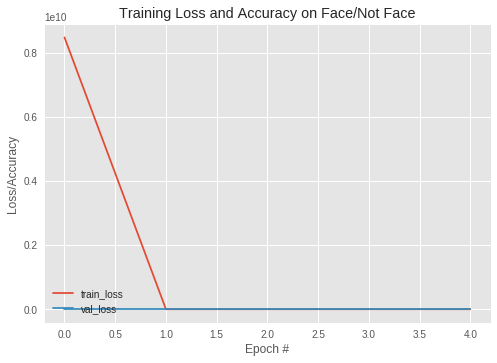

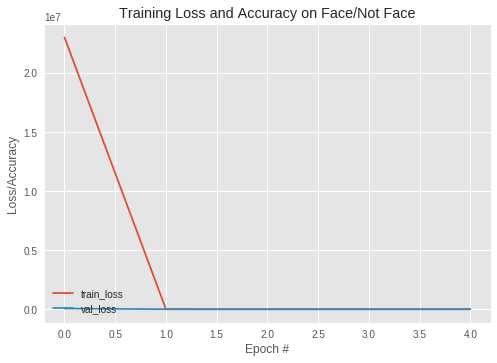

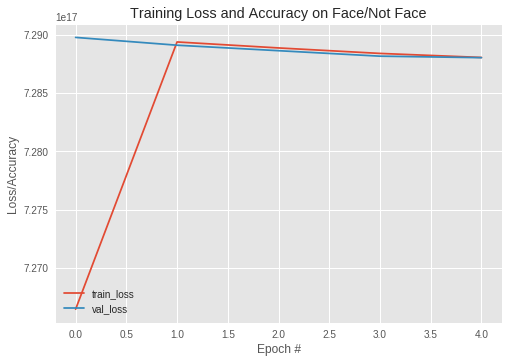

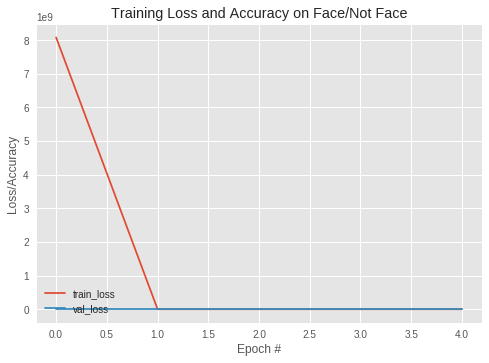

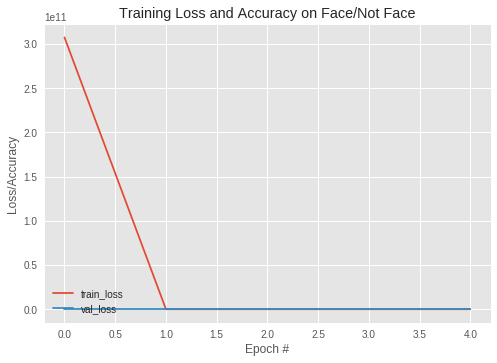

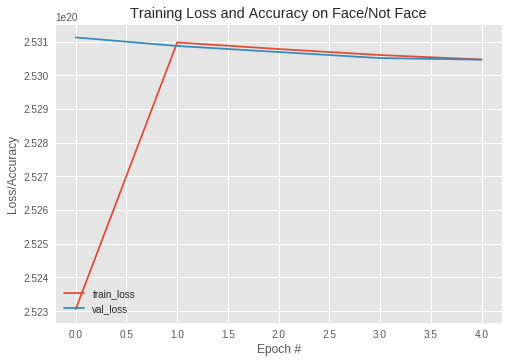

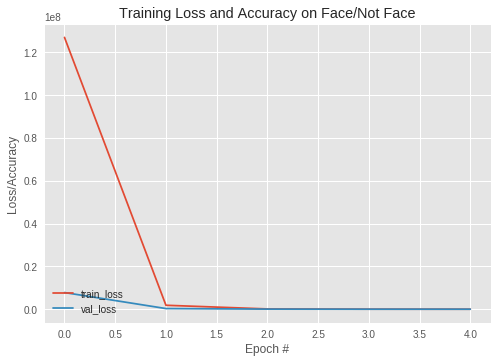

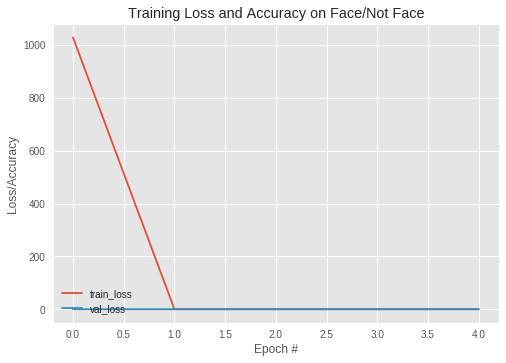

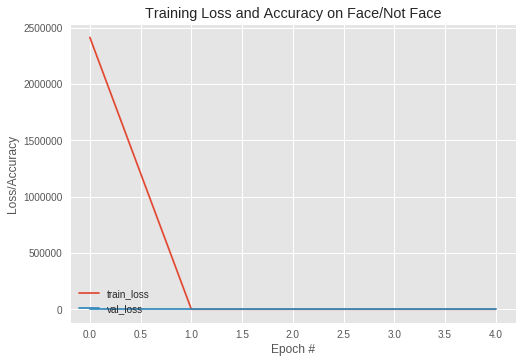

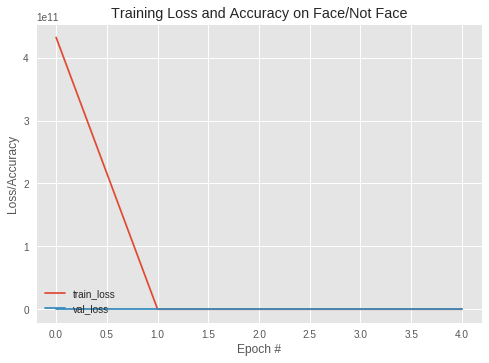

In [10]:
#Finer search
import random
limit = 10
for count in range(limit):
  reg = 10**random.uniform(1, 6)
  lr = 10**random.uniform(-3,9)
  print("Reg: "+str(reg)+", LR: " + str(lr))
  train_model(EPOCHS=5, INIT_LR=lr, regu = reg )

In [0]:
def train_model(EPOCHS,INIT_LR,regu):
  BS=50
  print("[INFO] loading images...")
  data = train_data
  labels = train_labels

  # Preprocessing of data
  # scale the raw pixel intensities to the range [0, 1]
  data = np.array(data, dtype="float") / 255.0
  labels = np.array(labels)
  # print("############")
  # print(data.shape)


  # Partition data into 75% training and 25% validation data
  (trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.25, random_state=42)

  # convert the labels from integers to vectors
  trainY = to_categorical(trainY, num_classes=2)
  testY = to_categorical(testY, num_classes=2)


  # initialize the model
  print("[INFO] compiling model...")
  model = LeNet.build(width=60, height=60, depth=3, classes=2, reg=regu)
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

  aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


  # train the network
  print("[INFO] training network...")
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)
  return model

## Train model with best param
## LR = 1e-5 and Reg = 1e2

In [51]:
model = train_model(EPOCHS = 5, INIT_LR = 1e-5, regu = 1e2)

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/5
300/300 [==============================] - 24s 81ms/step - loss: 78077.8795 - acc: 0.7813 - val_loss: 61921.2280 - val_acc: 0.8326
Epoch 2/5
166/300 [===============>..............] - ETA: 9s - loss: 54787.5710 - acc: 0.8336300/300 [==============================] - 23s 76ms/step - loss: 49719.8672 - acc: 0.8427 - val_loss: 39003.5990 - val_acc: 0.8374
Epoch 3/5
300/300 [==============================] - 23s 77ms/step - loss: 30934.3034 - acc: 0.8625 - val_loss: 23879.6405 - val_acc: 0.8816
Epoch 4/5
 73/300 [======>.......................] - ETA: 15s - loss: 22474.8823 - acc: 0.8723300/300 [==============================] - 23s 76ms/step - loss: 18636.9062 - acc: 0.8727 - val_loss: 14091.3738 - val_acc: 0.8918
Epoch 5/5
300/300 [==============================] - 23s 77ms/step - loss: 10780.5535 - acc: 0.8788 - val_loss: 7943.3604 - val_acc: 0.8982


## Evaluation of trained model with Testing data

In [3]:
def test_data(model):
  pred = []
  data = np.array(eval_data, dtype="float") / 255.0
  count = 1
  for image in eval_data:
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    (nf,f) = model.predict(image)[0]
    p = 1 if f>nf else 0
    pred.append(p)
    print(str(count)+": f = "+str(f)+"nf = "+str(nf)+", pred: "+str(p))
    count = count+1
  return pred

print(model)

## Calculate accuracy

In [54]:
match_count=0
eval_labels = [0]*1000+[1]*1000
pred = test_data(model)
print(pred)
print(eval_labels)

for x,y in zip(pred, eval_labels):
    if x==y:
        match_count+=1
accuracy = match_count/len(pred)


1: f = 1.0nf = 0.0, pred: 1
2: f = 0.0nf = 1.0, pred: 0
3: f = 1.0nf = 0.0, pred: 1
4: f = 1.0nf = 0.0, pred: 1
5: f = 0.0nf = 1.0, pred: 0
6: f = 0.0nf = 1.0, pred: 0
7: f = 0.0nf = 1.0, pred: 0
8: f = 1.8610338e-37nf = 1.0, pred: 0
9: f = 0.99999905nf = 9.063491e-07, pred: 1
10: f = 1.2856137e-22nf = 1.0, pred: 0
11: f = 0.0nf = 1.0, pred: 0
12: f = 0.0nf = 1.0, pred: 0
13: f = 1.0nf = 3.3726317e-17, pred: 1
14: f = 0.0nf = 1.0, pred: 0
15: f = 0.0nf = 1.0, pred: 0
16: f = 0.0nf = 1.0, pred: 0
17: f = 0.999424nf = 0.0005760014, pred: 1
18: f = 0.0nf = 1.0, pred: 0
19: f = 1.0nf = 1.4295934e-10, pred: 1
20: f = 0.0nf = 1.0, pred: 0
21: f = 1.0nf = 3.974185e-19, pred: 1
22: f = 1.0nf = 3.3018576e-29, pred: 1
23: f = 1.3674088e-19nf = 1.0, pred: 0
24: f = 0.0nf = 1.0, pred: 0
25: f = 0.0nf = 1.0, pred: 0
26: f = 0.0nf = 1.0, pred: 0
27: f = 0.0nf = 1.0, pred: 0
28: f = 1.0nf = 0.0, pred: 1
29: f = 0.0nf = 1.0, pred: 0
30: f = 1.0nf = 0.0, pred: 1
31: f = 1.0nf = 0.0, pred: 1
32: f = 0.9

611: f = 0.0nf = 1.0, pred: 0
612: f = 0.0nf = 1.0, pred: 0
613: f = 1.539733e-32nf = 1.0, pred: 0
614: f = 4.3758246e-34nf = 1.0, pred: 0
615: f = 0.0nf = 1.0, pred: 0
616: f = 0.0nf = 1.0, pred: 0
617: f = 0.0nf = 1.0, pred: 0
618: f = 1.7603159e-25nf = 1.0, pred: 0
619: f = 0.0nf = 1.0, pred: 0
620: f = 0.0nf = 1.0, pred: 0
621: f = 1.0nf = 2.6630906e-17, pred: 1
622: f = 0.0nf = 1.0, pred: 0
623: f = 0.9791053nf = 0.020894751, pred: 1
624: f = 0.0nf = 1.0, pred: 0
625: f = 0.0nf = 1.0, pred: 0
626: f = 1.0nf = 5.5758076e-30, pred: 1
627: f = 1.0nf = 1.619771e-22, pred: 1
628: f = 0.0nf = 1.0, pred: 0
629: f = 0.0048498125nf = 0.99515027, pred: 0
630: f = 3.8965632e-07nf = 0.99999964, pred: 0
631: f = 1.0nf = 0.0, pred: 1
632: f = 1.0nf = 9.371724e-16, pred: 1
633: f = 0.05198455nf = 0.9480155, pred: 0
634: f = 1.5627057e-15nf = 1.0, pred: 0
635: f = 0.0nf = 1.0, pred: 0
636: f = 1.0nf = 0.0, pred: 1
637: f = 0.0nf = 1.0, pred: 0
638: f = 1.0nf = 3.5569513e-26, pred: 1
639: f = 0.0n

1236: f = 1.0nf = 0.0, pred: 1
1237: f = 1.0nf = 0.0, pred: 1
1238: f = 1.0nf = 0.0, pred: 1
1239: f = 1.0nf = 8.056563e-37, pred: 1
1240: f = 1.0nf = 0.0, pred: 1
1241: f = 1.0nf = 3.191924e-33, pred: 1
1242: f = 1.0nf = 0.0, pred: 1
1243: f = 1.0nf = 0.0, pred: 1
1244: f = 1.0nf = 0.0, pred: 1
1245: f = 1.0nf = 0.0, pred: 1
1246: f = 1.0nf = 0.0, pred: 1
1247: f = 1.0nf = 0.0, pred: 1
1248: f = 1.0nf = 0.0, pred: 1
1249: f = 1.0nf = 0.0, pred: 1
1250: f = 1.0nf = 0.0, pred: 1
1251: f = 1.0nf = 0.0, pred: 1
1252: f = 1.0nf = 0.0, pred: 1
1253: f = 1.0nf = 0.0, pred: 1
1254: f = 1.0nf = 0.0, pred: 1
1255: f = 1.0nf = 0.0, pred: 1
1256: f = 1.0nf = 0.0, pred: 1
1257: f = 1.0nf = 0.0, pred: 1
1258: f = 1.0nf = 0.0, pred: 1
1259: f = 1.0nf = 0.0, pred: 1
1260: f = 1.0nf = 0.0, pred: 1
1261: f = 1.0nf = 0.0, pred: 1
1262: f = 1.0nf = 0.0, pred: 1
1263: f = 1.0nf = 0.0, pred: 1
1264: f = 1.0nf = 0.0, pred: 1
1265: f = 1.0nf = 0.0, pred: 1
1266: f = 1.0nf = 0.0, pred: 1
1267: f = 1.0nf = 0.0

1861: f = 1.0nf = 0.0, pred: 1
1862: f = 1.0nf = 0.0, pred: 1
1863: f = 1.0nf = 0.0, pred: 1
1864: f = 1.0nf = 0.0, pred: 1
1865: f = 1.0nf = 0.0, pred: 1
1866: f = 1.0nf = 0.0, pred: 1
1867: f = 1.0nf = 0.0, pred: 1
1868: f = 1.0nf = 0.0, pred: 1
1869: f = 1.0nf = 0.0, pred: 1
1870: f = 1.0nf = 0.0, pred: 1
1871: f = 1.0nf = 0.0, pred: 1
1872: f = 1.0nf = 0.0, pred: 1
1873: f = 1.0nf = 0.0, pred: 1
1874: f = 1.0nf = 0.0, pred: 1
1875: f = 1.0nf = 0.0, pred: 1
1876: f = 1.0nf = 0.0, pred: 1
1877: f = 1.0nf = 0.0, pred: 1
1878: f = 1.0nf = 0.0, pred: 1
1879: f = 3.375044e-10nf = 1.0, pred: 0
1880: f = 1.0nf = 0.0, pred: 1
1881: f = 1.0nf = 0.0, pred: 1
1882: f = 1.0nf = 0.0, pred: 1
1883: f = 1.0nf = 0.0, pred: 1
1884: f = 1.0nf = 0.0, pred: 1
1885: f = 1.0nf = 0.0, pred: 1
1886: f = 1.0nf = 0.0, pred: 1
1887: f = 1.0nf = 0.0, pred: 1
1888: f = 1.0nf = 0.0, pred: 1
1889: f = 1.0nf = 0.0, pred: 1
1890: f = 1.0nf = 0.0, pred: 1
1891: f = 1.0nf = 0.0, pred: 1
1892: f = 1.0nf = 0.0, pred: 1

In [55]:
print(accuracy)

0.8025
